# Visualizing Activation Distributions of Vision Transformers with Matplotlib

In [1]:
import os
import gc
import torch
from torchvision.transforms import v2
from torchvision import transforms
import torchvision
from copy import deepcopy as copy
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
from umap_pytorch import PUMAP_DDP, load_pumap
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
from torch.utils.data import DataLoader

from umap.umap_ import fuzzy_simplicial_set
from pynndescent import NNDescent
from sklearn.utils import check_random_state

/home/jroth/miniforge3/envs/lumenus/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def dino_model():
    os.environ['TORCH_HOME'] = './'
    os.environ['TORCH_HUB'] = './'
    # DINOv2 vit-s (14) with registers
    model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg')
    # state = model.state_dict()
    # mymodel = vit_small(14, 4)
    # mymodel.load_state_dict(state)
    model.eval()

    return model.to('cpu')

def dino_transforms():
    return v2.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        transforms.Resize(size=(256, 256), antialias=True),
                        transforms.CenterCrop((224, 224)),
                        transforms.Normalize(
                                            mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225]
                                            ),
                    ]
                    )

In [3]:
def get_activation(name):
    activations = []
    inputs = []
    def hook(model, input, output):
        activations.append(output.detach().clone()[:, 0].cpu().type(torch.float32))
        inputs.append(input[0].detach().clone()[:, 0].cpu().type(torch.float32))
    return hook, activations, inputs


def activationdist(network, test_loader, names, batches, dtype=torch.float32, silent=False):
    network = copy(network)
    network.eval().to(0)
    test_loss = 0
    correct = 0
    test_losses=[]

    dist_dict = {}
    in_dict = {}

    for name in names:
        hook, activations, inputs = get_activation(name)
        dist_dict[name] = activations
        in_dict[name] = inputs
        getattrrecur(network, name).register_forward_hook(hook)
    
    with torch.no_grad():
        for i, (data, target) in tqdm(enumerate(test_loader)):
            if i >= batches: 
                break
            output = network(data.to(0).type(dtype))

    return {k: torch.cat(dist_dict[k], 0) for k in dist_dict}, {k: torch.cat(in_dict[k], 0) for k in in_dict}

def linearleaves(module):
    # returns a list of pairs of (parent, submodule_name) pairs for all submodule leaves of the current module
    if isinstance(module, torch.nn.Linear):
        return [(module, None)]

    linear_children = []
    for name, mod in module.named_modules():
        if isinstance(mod, torch.nn.Linear):
            linear_children.append((name, module))
    return linear_children
        

def getattrrecur(mod, s):
    s = s.split('.')
    for substr in s:
        mod = getattr(mod, substr)
    return mod


def setattrrecur(mod, s, value):
    s = s.split('.')
    for substr in s[:-1]:
        mod = getattr(mod, substr)
    setattr(mod, s[-1], value)


def getlayernames(module):
    names = []

    for i, (name, mod) in enumerate(linearleaves(module)):
        names.append(name)

    return names

In [4]:
DINOv2 = dino_model()
DINOv2_transform = dino_transforms()

/home/jroth/miniforge3/envs/lumenus/lib/python3.10/site-packages/torch/hub.py:365: UserWarning: TORCH_HUB is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_HUB is deprecated, please use env TORCH_HOME instead')
Using cache found in ./hub/facebookresearch_dinov2_main
/home/jroth/Low-Rank-Model-Compression/./hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/jroth/Low-Rank-Model-Compression/./hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/jroth/Low-Rank-Model-Compression/./hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [5]:
train_ds = torchvision.datasets.CIFAR10('./cifar10', train=True, transform=DINOv2_transform, download=True)
val_ds = torchvision.datasets.CIFAR10('./cifar10', train=False, transform=DINOv2_transform, download=True)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=128)

Files already downloaded and verified
Files already downloaded and verified


#### Tradeoff between number of outputs and precision of outputs

It is clear that especially with large models modeling the activation distributions of the neurons is difficult due to the space requirement and there is a tradeoff between the precision of the stored activation distributions and the number of activations stored.  For large models and large datasets this space requirement can clearly extend into terrabytes.

Solutions:

- store the activations in lower precision
- offload the activations on disk
- store only a histogram of the activation distribution
- reduce the dimension of the activation distributions 

In [6]:
names = getlayernames(DINOv2)
activations, inputs = activationdist(DINOv2, val_loader, names, 1)

1it [00:00,  2.07it/s]


In [7]:
keys = [key for key in activations]
shapes = []

for key in keys:
    shapes.append(int(activations[key][0].shape[0]))

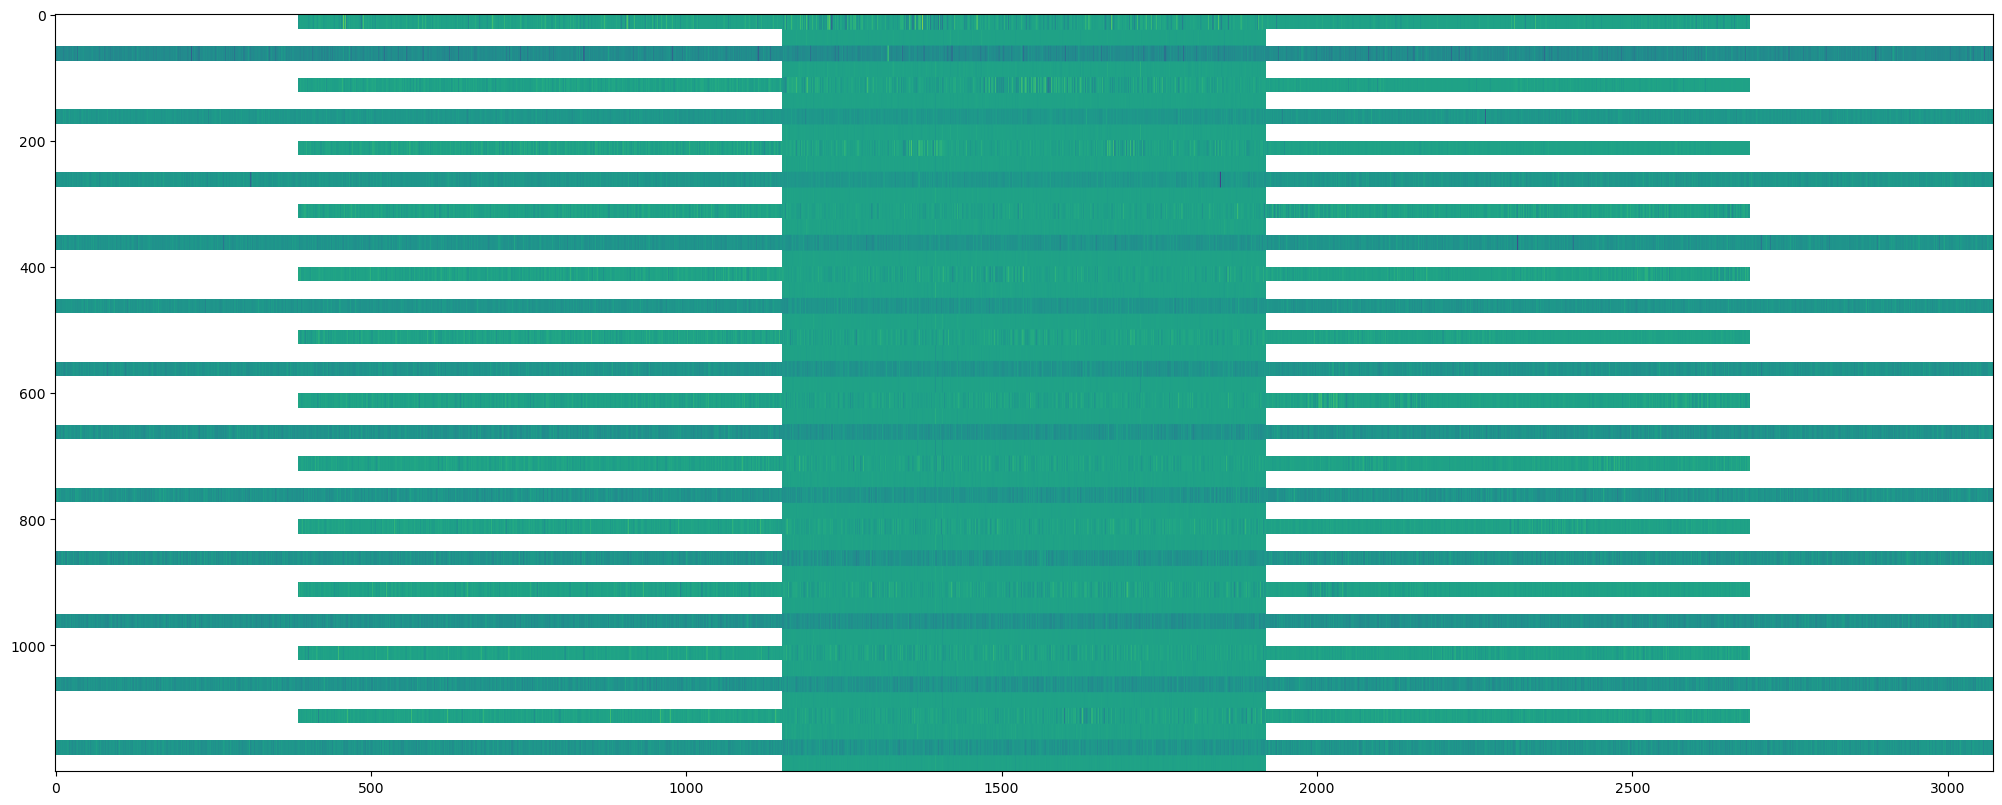

<Figure size 1920x1440 with 0 Axes>

In [8]:
fig, ax = plt.subplots(1, 1)
plt.rcParams['figure.dpi'] = 300
maxres = max(shapes)
tmp = np.zeros((len(shapes)*25, maxres))

for i, (key, shape) in enumerate(zip(keys, shapes)):
    pad = (maxres - shape) // 2
    tmp[25*i:25*i+25, pad:shape+pad] = activations[key][i]
    if pad > 0:
        tmp[25*i:25*i+25, :pad] = np.nan
        tmp[25*i:25*i+25, -pad:] = np.nan

ax.imshow(tmp)

fig.set_figheight(10)
fig.set_figwidth(25)

plt.show()
plt.clf()

# Computing the Distributions of Activation States

In [9]:

def batch_histogram(data_tensor, bins=10, bin_edges=None, interval=None):
    """
    computes a 1d histogram for each position in the last dimension of the tensor over all 
    values in that position over the flattened first k-1 dimensions, e.g activations of neurons
    in a layer over a batch of samples
    """

    data_tensor = data_tensor.flatten(0, -2)

    mind, maxd = (data_tensor.min(), data_tensor.max()) if interval is None else interval

    if bin_edges is None:
        bin_edges = (torch.arange(1, bins) - mind) / (maxd - mind)

    nc = len(bin_edges) + 1

    hist = torch.zeros((data_tensor.shape[-1], nc), dtype=data_tensor.dtype, device=data_tensor.device)

    hist[..., 0] += (data_tensor < bin_edges[0]).type(torch.int32).sum(0)

    for i in tqdm(range(len(bin_edges) - 1)):
        hist[..., i+1] += ((data_tensor >= bin_edges[i])*(data_tensor < bin_edges[i + 1])).type(torch.int32).sum(0)

    hist[..., -1] += (data_tensor >= bin_edges[-1]).type(torch.int32).sum(0)

    return hist, bin_edges


class Histogram:
    def __init__(self, bins, interval, density = False):
        self.bins = bins
        self.interval = interval
        self.histogram = None
        self.bin_edges = None

    def __call__(self, array):
        if self.histogram is None:
            self.histogram, self.bin_edges = batch_histogram(array, self.bins, interval=self.interval)
        else:
            hist, bin_edges = batch_histogram(array, self.bins, interval=self.interval)
            assert torch.equal(self.bin_edges, bin_edges), 'bin edges missmatch'
            self.histogram += hist

def hist_batch(hist, batch):
    hist(batch)
    return hist

In [10]:
activation_histogram = Histogram(1000, (-30, 30))

activation_histogram = hist_batch(activation_histogram, activations[keys[0]].to(0))

100%|██████████| 998/998 [00:00<00:00, 41139.62it/s]


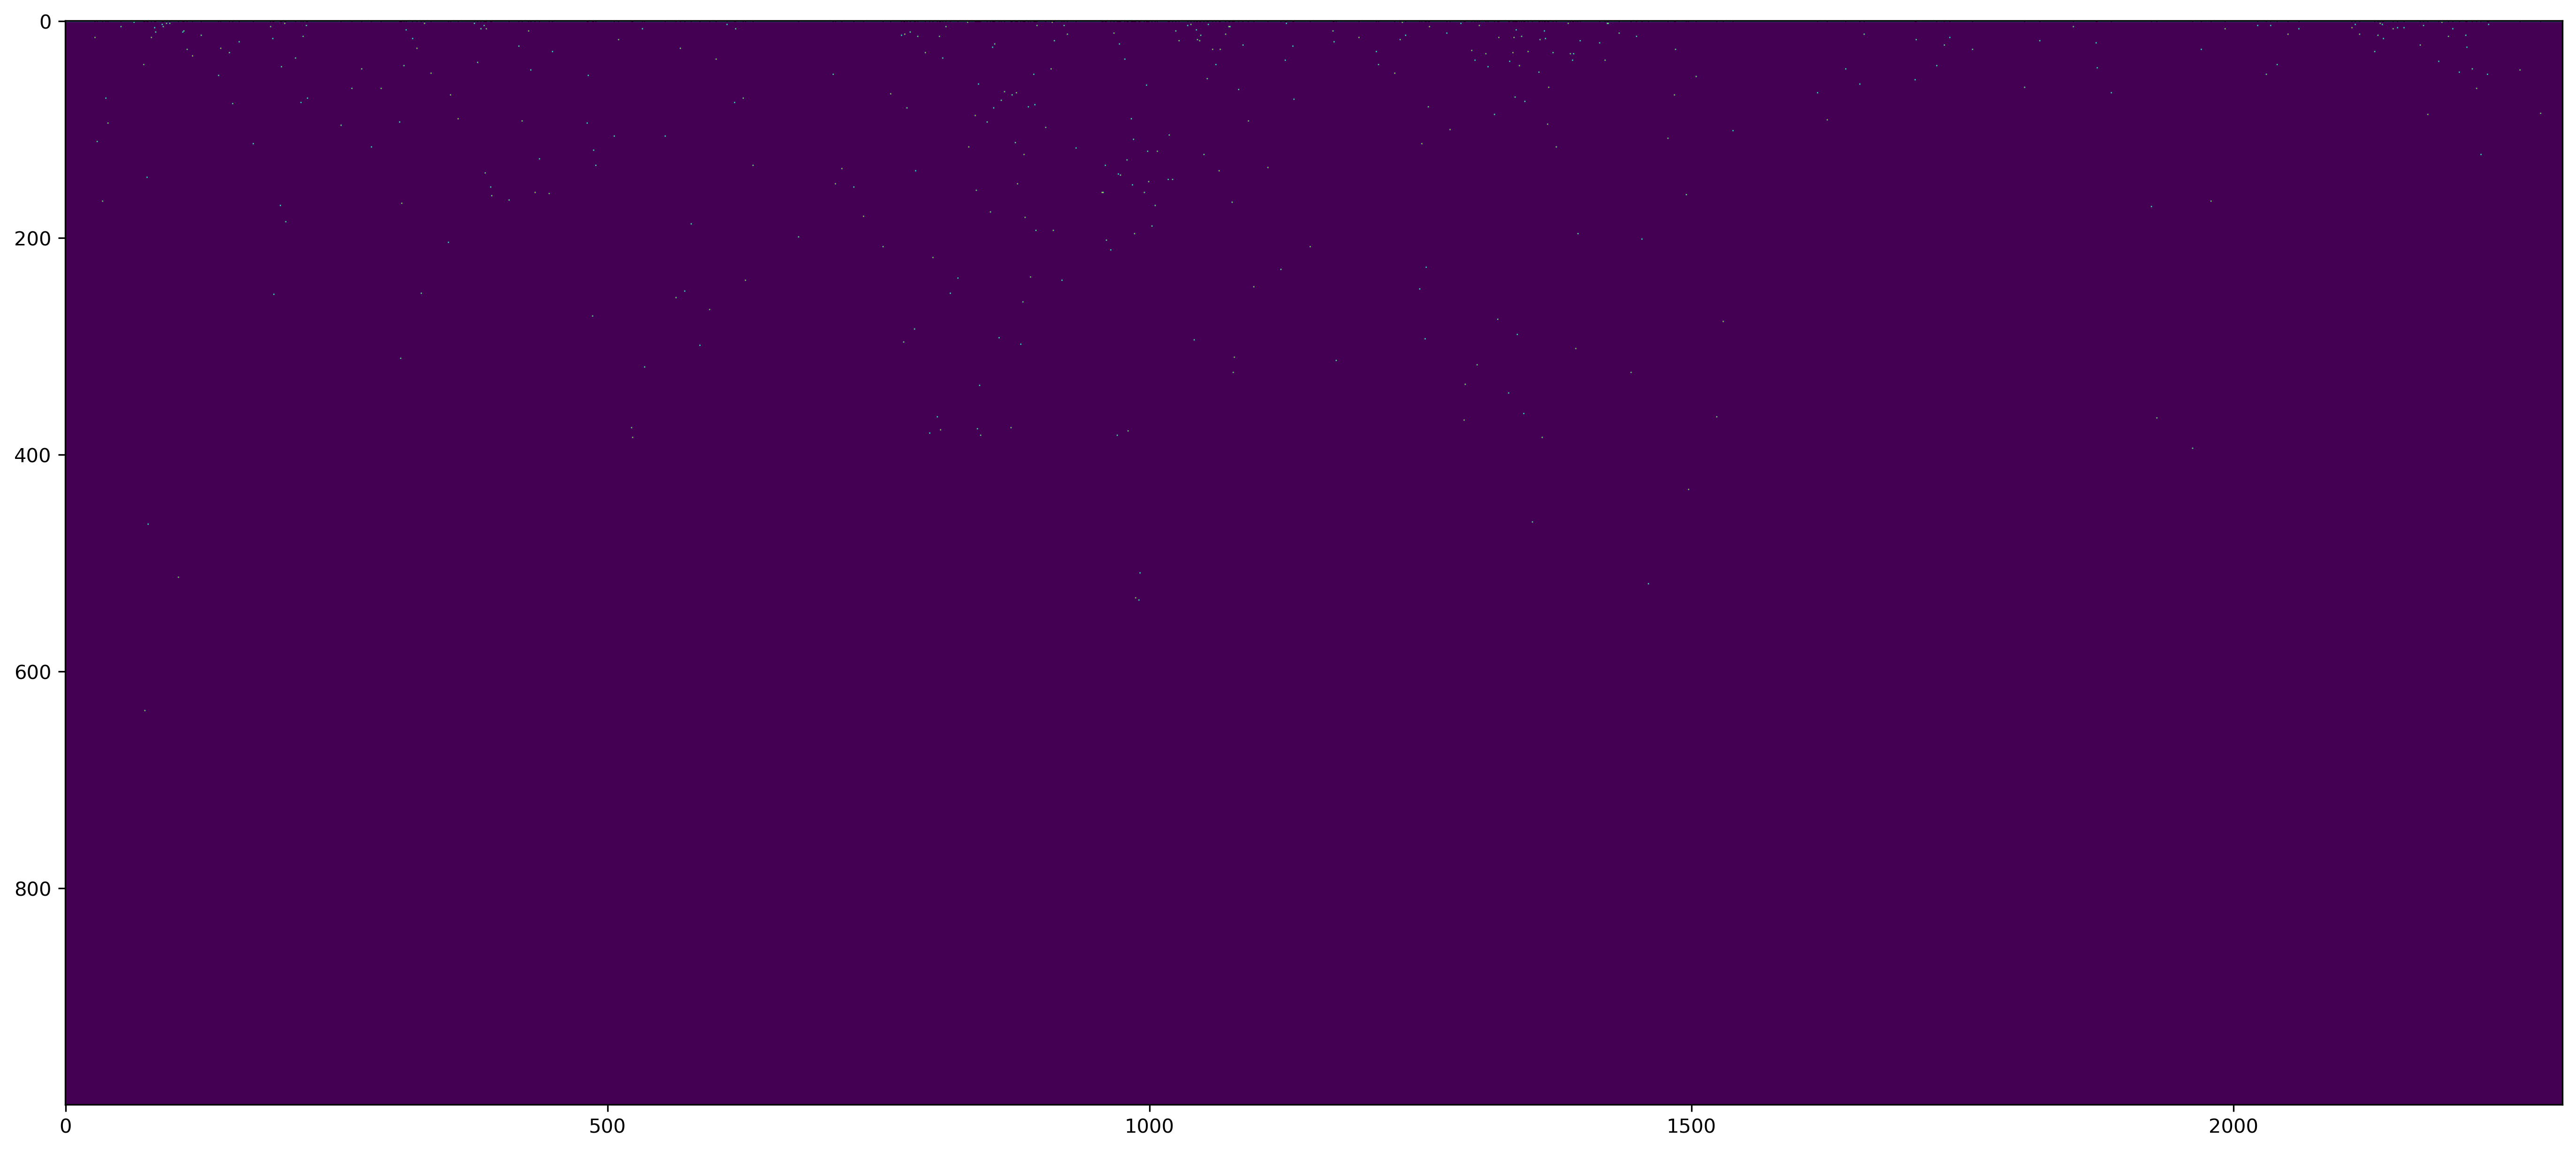

<Figure size 1920x1440 with 0 Axes>

In [11]:
hist = activation_histogram.histogram.cpu()

fig, ax = plt.subplots(1, 1)
plt.rcParams['figure.dpi'] = 300
maxres = hist.shape[0]
tmp = np.zeros((hist.shape[1], maxres))

tmp = hist.permute(1, 0)

ax.imshow(tmp)

fig.set_figheight(10)
fig.set_figwidth(25)

plt.show()
plt.clf()

In [12]:
activation_states = torch.cat([activations[key].flatten(1, -1) for key in keys], -1)

In [13]:
import sys
# 22 gigabytes at a float16 if we use all tokens, 85 MB for the class token only
sys.getsizeof(activation_states)+ torch.numel(activation_states)*activation_states.element_size()
# so, at this precision we can get roughly 2500 activation states into 1TB of RAM

42467408

#### Coping with massive activation states

In their paper the authors of CCS take only the activations for the last token in the sequence.  This is strange to me as it seems like a cost-saving measure that is poorly motivated.  For vision transformers with registers it may make sense to take only the register tokkens, but otherwise it is unclear how one could capture the global activation state without intermediate representations of spatial features.  Still, they also use very few samples and thus have no indication for how they would solve the problem that the samples are massive.

Dimensionality reduction seems natural, though if the goal is to perform model compression or knowledge extraction we will have to consider very careful the ways in which we choose to reduce the dimension so that we can maintain the performance of the model and the fidelity of the knowledge.

# Reducing the Dimension of Activation States with UMAP

### Improving upon the distance metric

The use of linear correlation satisfies our two requirements for a distance measure for UMAP:
- we know how to produce a new layer of reduced neurons
- we know how to combine their outputs for the future layers (how to modify future layers' input weights)

However, this requirement is also satisfied by polynomial regression error for some degree polynomial

The use of linear correlation here does cover neurons which are coincidentally related but not those whose linear 

In [14]:
key = 'blocks.1.mlp.fc2'

layer = getattrrecur(DINOv2, 'blocks.1.mlp')
act = getattrrecur(DINOv2, 'blocks.1.mlp.act')

ds = torch.cat((getattrrecur(DINOv2, key).weight, getattrrecur(DINOv2, key).bias.unsqueeze(-1)), -1).detach().clone()

In [24]:
def cache_tensor(func):
    global most_recent
    global out

    most_recent = None
    out = None

    def wrapper(tensor):
        global most_recent
        global out

        if most_recent is not None:
            if torch.equal(most_recent, tensor):
                return out
        most_recent = tensor
        out = func(tensor)
        return out

    return wrapper

@cache_tensor
def transpose_invert_multiply(X):
    gc.collect()
    mats = []
    vec=32
    for i in tqdm(range(0, X.shape[0], vec)):
        mats.append(torch.bmm(X[i:i+vec].type(torch.float32), X[i:i+vec].transpose(1, 2).type(torch.float32)).type(torch.float16).cpu())

    XXT = torch.cat(mats, 0) 
    mats.clear()
    gc.collect()

    # very possible at low precision that activations which are always close to zero yield a 0 diagonal element.
    for i in range(XXT.shape[1]):
        # XXT is positive along the diagonal always
        XXT[:, i, i] += XXT[:, i, i] + (torch.full_like(XXT[:, i, i], 1e-8) - XXT[:, i, i].abs()).relu()

    gc.collect()

    for i in tqdm(range(0, XXT.shape[0])):
        # we have to sync with the CPU to effectively use our space here
        # unless we are really vectorizing then inv_ex will not save us much time
        # also, it will not throw an error for us.
        XXT[i] = torch.linalg.inv(XXT[i].to(0).type(torch.float32))[0].type(torch.float16).cpu()
    gc.collect()

    for i in tqdm(range(0, X.shape[0], vec)):
        mats.append(torch.bmm(XXT[i:i+vec].type(torch.float32).to(0), X[i:i+vec].type(torch.float32).to(0)).type(torch.float16).cpu())

    return XXT

def batch_linear_regression(X, y):
    """
    computes the linear regression weights, biases, and errors between the variables in a batch of examples

    X a batch of matrices whose columns are observations and whose rows are variables

    y a batch of matrices whose columns are outputs and rows are output variables

    returns

    w a matrix of weights for each element in the batch

    b a bias constant for each element in the batch

    errors the error for each regression
    """
    X, y = X.type(torch.float32).to(0), y.type(torch.float32).to(0)

    print(y.shape)
    
    # compute the linear regression weights and biases for each pair using the input 
    X = torch.cat((X, torch.ones_like(X)[:, -1].unsqueeze(1)), 1)
    w = torch.bmm(transpose_invert_multiply(X).to(0), y)

    errors = (((torch.bmm(w.transpose(1, 2), X) - y)**2).sum(-1) / X.shape[0])

    w, b = w[:, :-1], w[:, -1].unsqueeze(-1)

    return w, b, errors

def activation_correlations(key):
    w, b, errors = None, None, None

    key_activations = act(activations[key]).T.unsqueeze(1).expand(-1, act(activations[key]).shape[-1], -1)

    for i in tqdm(range(key_activations.shape[-1])):
        if w is None or b is None or errors is None:
            w, b, errors = batch_linear_regression(key_activations, key_activations)
        else:
            w_i, b_i, errors_i = batch_linear_regression(key_activations, key_activations.roll(i, 0))

            w, b, errors = torch.cat((w, w_i), 1), torch.cat((b, b_i), 1), torch.cat((errors, errors_i), 1)
        
    for i in range(key_activations.shape[-1]): # seems like there should be a faster way to do this...
        w[i], b[i], errors[i] = w[i].roll(i, 0), b[i].roll(i, 0), errors[i].roll(i, 0)

    return w, b, errors

In [ ]:
act(activations[key]).T.unsqueeze(1).expand(-1, act(activations[key]).shape[-1], -1)

In [25]:
gc.collect()
activation_correlations(key)

  0%|          | 0/128 [00:00<?, ?it/s]

torch.Size([768, 768, 128])


  0%|          | 0/128 [00:02<?, ?it/s]


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [768, 769] but got: [768, 768].

In [21]:
key_activations = act(activations[key]).T.unsqueeze(0).expand(act(activations[key]).shape[-1], -1, -1)
X = torch.cat((key_activations, torch.ones_like(key_activations)[:, -1].unsqueeze(1)), 1).to(0)

transpose_invert_multiply(X).shape

100%|██████████| 24/24 [00:00<00:00, 94.35it/s]


torch.Size([768, 769, 769])

#### How to change the weights of inputs to future neurons

We will assume that the new neuron is the average of its nearest neighbors.  This will give us the weight and bias of the new neuron with respect to all others as the correlation-weighted average, i.e. the average of all k biases plus the dot product of the input weights and the correlation coefficients is the new input weight corresponding to the pooled output.

In [31]:
def get_knn_and_umap_from_key(key, n_neighbors=10, metric="l1", random_state=None):
    random_state = check_random_state(None) if random_state == None else random_state

    w, b, errors = activation_correlations(key)

    knn_dists, knn_inds = torch.sort(errors, -1)
    # build fuzzy_simplicial_set
    umap_graph, sigmas, rhos = fuzzy_simplicial_set(
        X = ds,
        n_neighbors = n_neighbors,
        metric = metric,
        random_state = random_state,
        knn_indices= knn_inds[1:].cpu().numpy(),
        knn_dists = knn_dists[1:].cpu().numpy(),
    )
    
    return umap_graph, knn_inds, (w, b, errors)


umap_graph, knn_inds, (w, b, errors) = get_knn_and_umap_from_key(key, n_neighbors=10, metric="l1", random_state=13)

  0%|          | 0/128 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 108.07 GiB. GPU 0 has a total capacty of 23.65 GiB of which 12.86 GiB is free. Including non-PyTorch memory, this process has 9.66 GiB memory in use. Of the allocated memory 9.05 GiB is allocated by PyTorch, and 16.95 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [17]:
class EarlyStopper:
    def __init__(self,
                 mode: callable = min,
                 patience: int = 10,
                 min_delta: float = 0.0):
        
        self.mode = mode
        self.patience = patience
        self.min_delta = min_delta

        self.early_stop = False
        self.epochs_since_improvement = 0
        self.best = float('inf') if mode == min else -1*float('inf')

    def step(self, new: float):
        self.epochs_since_improvement += 1
        best = self.mode(self.best + self.min_delta, self.best - self.min_delta)
        if self.mode(new, best) != best:
            self.epochs_since_improvement = 0
            self.best = self.mode(self.best, new)
        if self.epochs_since_improvement > self.patience:
            self.early_stop = True

os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '1337'
os.environ['WORLD_SIZE'] = '1'
os.environ['RANK'] = '0'

def setup():
    dist.init_process_group("nccl", rank=0, world_size=1)


def cleanup():
    dist.destroy_process_group()

In [18]:
setup()

In [19]:
n_components = 2

enc = torch.nn.Sequential(torch.nn.Linear(ds.shape[-1], 512), torch.nn.ReLU(), torch.nn.Linear(512, n_components)).to(0)
enc = DDP(enc, device_ids=[0], find_unused_parameters=True)

dec = torch.nn.Sequential(torch.nn.Linear(n_components, 512), torch.nn.ReLU(), torch.nn.Linear(512, ds.shape[-1])).to(0)
dec = DDP(dec, device_ids=[0], find_unused_parameters=True)

torch.autograd.set_detect_anomaly(True)

# TODO
# 1. Add a decoder
# 2. replace the encoder with something that makes sense

pumap = PUMAP_DDP(
    encoder=enc,
    decoder=dec,
    reconstruction_loss=torch.nn.MSELoss(),
    n_neighbors=3,
    min_dist=1e-1,
    metric="l1",
    n_components=n_components,
    beta=1e-2,
    random_state=13,
    lr=1e-4,
    epochs=1,
    batch_size=32,
    num_workers=12,
    match_nonparametric_umap=False,
    accumulate=1,
)
scheduler = None
stopper = EarlyStopper(patience=3)

### Interpreting fitting metrics from this version of UMAP

- what does overfitting even mean here?

overfitting here means that the new neurons generated do not correlate well with activations on the validation set when they do on the training set

**TODO**:

There is an additional axis of evaluation, 'faithfullness' that indicates whether or not a neuron that is generated induces an activation distribution that correlates with the correlation-weighted average of its local neighborhood.  We can enforce this property by iteratively re-training with points sampled as centroids of local neighborhoods or points on the k-simplex between other points.

**TODO**:
We need to evaluate for both "faithfulness" and "fitness"

- our datasets are perpetually "small" - does that even matter?

No, with pseudo-labels our dataset can be as large as we want.

- it seems like we should spectral reg these weight matrices for sure... 

Yes.

In [20]:
def validation_activation_loss(pumap, key):
    encoded = pumap.encoder(ds).detach()
    decoded = pumap.decoder(encoded).detach()
    layer = copy(getattrrecur(DINOv2, key))
    layer.weight.data = decoded[..., :-1].detach().to(0)
    layer.bias.data = decoded[..., -1].detach().to(0)

    val_loss = torch.nn.MSELoss()(act(layer(inputs[key].to(0))).detach().type(torch.float16), act(activations[key]).to(0)).detach().cpu().item()
    return val_loss

loader = DataLoader(ds, 64)

epochs = 25

for e in range(epochs):
    train_loss = pumap.fit(loader, umap_graph)
    
    print('Validation Loss:', validation_activation_loss(pumap, key))
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(pumap.opt, factor=0.5) if scheduler is None else scheduler

    scheduler.step(train_loss), stopper.step(train_loss)
    
    if stopper.early_stop:
        break


100%|██████████| 96/96 [00:01<00:00, 76.88it/s] 


Train Epoch: 0 	Average Loss: 0.656479
Validation Loss: 0.011901883408427238


100%|██████████| 96/96 [00:00<00:00, 101.59it/s]


Train Epoch: 0 	Average Loss: 0.507611
Validation Loss: 0.007011787034571171


100%|██████████| 96/96 [00:00<00:00, 102.88it/s]


Train Epoch: 0 	Average Loss: 0.363214
Validation Loss: 0.007347671315073967


100%|██████████| 96/96 [00:00<00:00, 104.44it/s]


Train Epoch: 0 	Average Loss: 0.267910
Validation Loss: 0.0076677231118083


100%|██████████| 96/96 [00:00<00:00, 100.97it/s]


Train Epoch: 0 	Average Loss: 0.213922
Validation Loss: 0.007968880236148834


100%|██████████| 96/96 [00:00<00:00, 99.39it/s] 


Train Epoch: 0 	Average Loss: 0.176715
Validation Loss: 0.0075933560729026794


100%|██████████| 96/96 [00:00<00:00, 106.28it/s]


Train Epoch: 0 	Average Loss: 0.151669
Validation Loss: 0.00760663440451026


100%|██████████| 96/96 [00:00<00:00, 105.58it/s]


Train Epoch: 0 	Average Loss: 0.132430
Validation Loss: 0.007657211273908615


100%|██████████| 96/96 [00:00<00:00, 104.94it/s]


Train Epoch: 0 	Average Loss: 0.120432
Validation Loss: 0.007136824540793896


100%|██████████| 96/96 [00:00<00:00, 102.11it/s]


Train Epoch: 0 	Average Loss: 0.111381
Validation Loss: 0.008372925221920013


100%|██████████| 96/96 [00:00<00:00, 103.90it/s]


Train Epoch: 0 	Average Loss: 0.103886
Validation Loss: 0.007250487804412842


100%|██████████| 96/96 [00:00<00:00, 102.53it/s]


Train Epoch: 0 	Average Loss: 0.097371
Validation Loss: 0.00796697847545147


100%|██████████| 96/96 [00:00<00:00, 106.92it/s]


Train Epoch: 0 	Average Loss: 0.092595
Validation Loss: 0.007386740297079086


100%|██████████| 96/96 [00:00<00:00, 107.39it/s]


Train Epoch: 0 	Average Loss: 0.088847
Validation Loss: 0.007702776230871677


100%|██████████| 96/96 [00:00<00:00, 106.10it/s]


Train Epoch: 0 	Average Loss: 0.085112
Validation Loss: 0.007506412919610739


100%|██████████| 96/96 [00:00<00:00, 102.42it/s]


Train Epoch: 0 	Average Loss: 0.082816
Validation Loss: 0.007052232511341572


100%|██████████| 96/96 [00:00<00:00, 106.40it/s]


Train Epoch: 0 	Average Loss: 0.080151
Validation Loss: 0.006951626390218735


100%|██████████| 96/96 [00:00<00:00, 102.38it/s]


Train Epoch: 0 	Average Loss: 0.078248
Validation Loss: 0.007753537502139807


100%|██████████| 96/96 [00:00<00:00, 101.77it/s]


Train Epoch: 0 	Average Loss: 0.076374
Validation Loss: 0.008051419630646706


100%|██████████| 96/96 [00:00<00:00, 103.98it/s]


Train Epoch: 0 	Average Loss: 0.076080
Validation Loss: 0.0077253058552742004


100%|██████████| 96/96 [00:00<00:00, 100.96it/s]


Train Epoch: 0 	Average Loss: 0.073482
Validation Loss: 0.006610750686377287


100%|██████████| 96/96 [00:00<00:00, 102.80it/s]


Train Epoch: 0 	Average Loss: 0.073092
Validation Loss: 0.006927439942955971


100%|██████████| 96/96 [00:00<00:00, 103.80it/s]


Train Epoch: 0 	Average Loss: 0.071600
Validation Loss: 0.007282438687980175


100%|██████████| 96/96 [00:00<00:00, 103.81it/s]


Train Epoch: 0 	Average Loss: 0.071247
Validation Loss: 0.006948786787688732


100%|██████████| 96/96 [00:00<00:00, 104.56it/s]

Train Epoch: 0 	Average Loss: 0.069890
Validation Loss: 0.007700933143496513


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


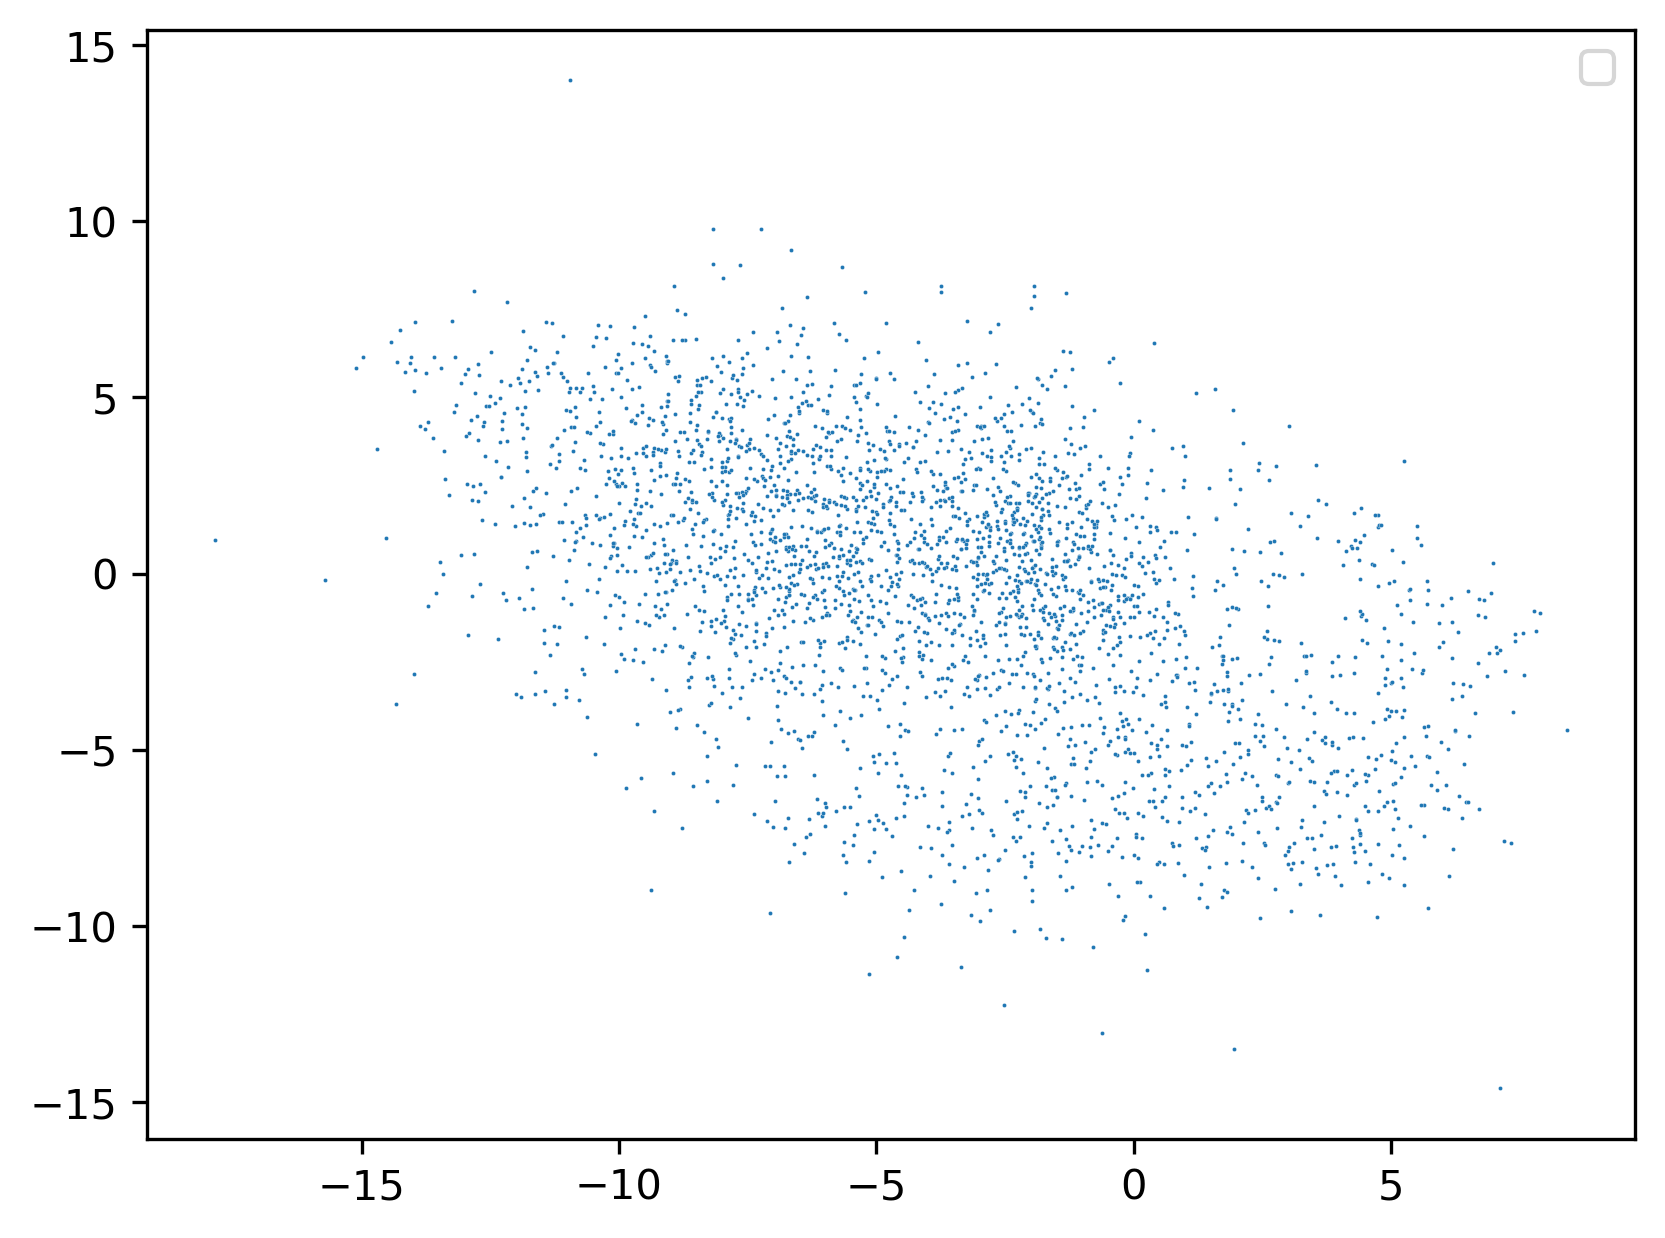

<Figure size 1920x1440 with 0 Axes>

In [21]:
import seaborn as sns

embedding = pumap.encoder(loader.dataset).detach().cpu().numpy()

sns.scatterplot(x=embedding[:,0], y=embedding[:,1], s=1.0)
plt.legend(markerscale=100)
plt.show()
plt.clf()

In [22]:
embedding.shape

(3072, 2)

In [23]:
embedding = torch.tensor(embedding)
sorted, inds = (embedding.unsqueeze(0) - embedding.unsqueeze(1)).abs().sum(-1).sort(-1)

In [24]:
sorted, inds

(tensor([[ 0.0000,  6.9763,  7.2452,  ..., 40.1423, 40.3841, 46.6527],
         [ 0.0000,  0.3111,  0.4111,  ..., 19.5053, 22.1878, 24.4648],
         [ 0.0000,  0.8085,  0.9739,  ..., 29.4213, 29.6631, 35.9317],
         ...,
         [ 0.0000,  0.1660,  0.2277,  ..., 23.7356, 23.9775, 30.2460],
         [ 0.0000,  0.3777,  0.4287,  ..., 19.9787, 22.9060, 23.7467],
         [ 0.0000,  0.2617,  0.3142,  ..., 29.5191, 29.7610, 36.0296]]),
 tensor([[   0, 2899, 1060,  ...,   32, 2206, 1778],
         [   1, 1328, 1897,  ..., 2366,    0, 1778],
         [   2,  118, 1339,  ...,   32, 2206, 1778],
         ...,
         [3069, 2892,  413,  ...,   32, 2206, 1778],
         [3070, 2872,  559,  ..., 1704, 1778,    0],
         [3071, 2732, 1113,  ...,   32, 2206, 1778]]))

In [25]:
s, i = sorted.sort(0)
i

tensor([[2052, 2030,  946,  ..., 2891, 1359, 1571],
        [2041, 2417,  680,  ...,  946, 3034,  559],
        [2042, 1569,  581,  ...,  581, 1922,  320],
        ...,
        [1029,  653, 2206,  ..., 2206, 1704, 1704],
        [1030, 1778, 1778,  ...,    0,    0, 1778],
        [1031,    0,    0,  ..., 1778, 1778,    0]])

In [26]:
sorted[2718], inds[2718]

(tensor([ 0.0000,  0.2071,  0.6202,  ..., 28.4639, 28.7058, 34.9743]),
 tensor([2718, 2839, 1868,  ...,   32, 2206, 1778]))

In [27]:
errors[2718, 1031], w[2718, 1031], b[2718, 1031]

IndexError: index 1031 is out of bounds for dimension 1 with size 128

In [ ]:
errors[1031, 2718], w[1031, 2718], b[1031, 2718]

(tensor(9.5906e-07, device='cuda:0'),
 tensor([0.7068], device='cuda:0'),
 tensor([-0.0606], device='cuda:0'))

In [ ]:
def neuron_MSE(old_layer_inds, old_layer_weights, old_layer_offsets, new_layer, key):
    layer = copy(getattrrecur(DINOv2, key))

    layer.weight.data[-1] = new_layer[..., :-1].detach().to(0)
    layer.bias.data[-1] = new_layer[..., -1].detach().to(0)

    val_loss = torch.nn.MSELoss()(act(layer(inputs[key].to(0))).detach().type(torch.float16)[..., -1], =).detach().cpu().item()
    return val_loss

# merge the neurons in the compressed space
merged = (embedding[3070] + embedding[2809]) / 2
# reconstruct it
pumap.decoder(merged).detach()

tensor([-1.3721e-02, -7.7236e-03,  8.6627e-03, -1.3818e-02,  1.8871e-03,
         5.2712e-03, -1.3504e-02, -6.1070e-03,  4.3877e-03, -3.0955e-03,
         1.0592e-03, -6.9972e-03,  7.7244e-03, -1.6456e-03,  2.4914e-02,
         4.3508e-03, -1.2350e-02, -2.1247e-02, -6.9271e-03, -8.2968e-03,
         1.3785e-02,  2.4938e-03,  2.2660e-02, -4.7342e-03,  1.6924e-03,
        -3.4868e-03, -4.8827e-03,  9.0095e-03, -6.7234e-03, -2.5372e-02,
         2.1753e-02, -2.0919e-02, -1.9334e-02,  2.3832e-04, -2.9176e-03,
         1.9418e-02,  1.2339e-02,  6.3552e-03, -4.7934e-03,  1.1497e-03,
         1.8800e-02, -1.5599e-02, -1.4863e-02,  2.1968e-03,  1.1717e-02,
         1.2609e-02,  1.9141e-03,  5.3769e-04,  5.0146e-03, -1.1448e-02,
        -3.2930e-03, -1.4932e-04, -1.2829e-02, -8.3161e-03, -3.1372e-03,
        -4.5319e-03, -7.2022e-04,  1.1095e-03, -1.7500e-03, -5.1512e-04,
        -9.5358e-04,  3.7083e-04,  7.8573e-03,  7.1160e-05,  4.7298e-03,
        -1.0967e-03, -6.0256e-03,  1.8449e-02, -8.2

In [ ]:
getattrrecur(DINOv2, 'blocks.1'), getattrrecur(DINOv2, 'blocks.1.mlp.fc1')

(NestedTensorBlock(
   (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
   (attn): MemEffAttention(
     (qkv): Linear(in_features=768, out_features=2304, bias=True)
     (attn_drop): Dropout(p=0.0, inplace=False)
     (proj): Linear(in_features=768, out_features=768, bias=True)
     (proj_drop): Dropout(p=0.0, inplace=False)
   )
   (ls1): LayerScale()
   (drop_path1): Identity()
   (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
   (mlp): Mlp(
     (fc1): Linear(in_features=768, out_features=3072, bias=True)
     (act): GELU(approximate='none')
     (fc2): Linear(in_features=3072, out_features=768, bias=True)
     (drop): Dropout(p=0.0, inplace=False)
   )
   (ls2): LayerScale()
   (drop_path2): Identity()
 ),
 Linear(in_features=768, out_features=3072, bias=True))

In [ ]:
import torch

torch.arange(10).unsqueeze(1).expand(10, -1)

tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]])

#### The first question to ask is "what are we reducing?"

If our goal is to compress an existing model while retaining performance and usability, then our options for dimensionality reduction of the activation states is much lower.  If our goal is discovering the knowledge within the knowledge then the application is not tied to a specific architecture.

UMAP dimensionality reduction has two components:
- a distance metric in the underlying space
- an adjacentcy matrix between the elements

# Using Activation State Dimensionality Reduction for Model Compression

The underlying goal of the compression is to provide a minimal transformation from the input distribution of activation vectors from the previous layer to a distribution which is equivalent up to a linear transformation of the output distribution, e.g. some transformation f_min which transforms D(A) where D is the data distribution over the input space A to D(B) where D is the data distribution over the output space B such that f_min(D(A)) is approximately equal to L(D(B)) for some linear transformation L and D(B) = f(D(A)) where f is the original non-linear transformation.  We can use a suitable distance metric to judge the divergence of the distributions such as the wasserstein distance (which is approximable by a differentiable quadratic program, though this is slow as hell) or the KL divergence.

To find such a transformation f_min it is sufficient in the case of linear f to find some linear transformation f_min through performing a principal component analysis of D(B) and then combining the rows of the linear weight matrix according to the combination that defines principal components, or more explicitly multiplying the weight matrix by the compression matrix.  E.g. what was W^tx becomes UW^tx = (UW^t)x = W'^tx

For non-linear transformations f we are asking to do something more general and more complicated.

We can UMAP (with reconstruction) the neuron weights and use the absolute correlation between the activations as the similarity.  This isn't as general as the previous method in that it uses linear correlation instead of a non-linear similarity metric like the wasserstein distance between the output distributions, but it does yield the linear transformation we need to know.  If the distance metric in the underlying space is a p-norm then we can cluster the neurons, compute the centroids, reconstruct the centroid point, and then combine the colums of the next layer (define L) according to the correlation coefficients

#### Reducing the Neurons in each Layer

Using UMAP to reduce the number of neurons in each layer is fairly straightforward.  We will reduce the dimensionality of the activation state using parametric UMAP, we will cluster the resulting low-dimensional vectors and use the reconstructions of the centroids as the new neurons.  If we are careful about the extent to which we reduce each layer, respect the shapes of skip connections, and aggregate inputs in subsequent layers appropriately then the function of the network is relatively unimpacated.

In order to successfully create reconstructions that serve the purpose of the original neurons we have to correctly define the adjacentcy matrix.  In this case it should be some correlation metric between the activation of each neuron.  This metric will impact how the inputs to future neurons should be activated.  If we use the linear correlation matrix as the adjacentcy matrix then we know what the centroid means - it is the average of the correlated activations, so we compute the mean of the input weights.

In [ ]:
rand = torch.rand(3, 3)
rand[torch.where(rand < 0.5)] = 0
rand = rand.to_sparse()
rand @ torch.eye(3) # is dense
torch.eye(3) @ rand # is dense
torch.eye(3).to_sparse() @ rand # is sparse

# rand.to_sparse(sparse_dim=1) # only sparsify across one dimension, useful for removing neurons

/tmp/ipykernel_2930473/3782066932.py:6: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1715184473142/work/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  torch.eye(3).to_sparse() @ rand # is sparse


tensor(indices=tensor([[0, 0, 1, 1, 2, 2, 2],
                       [0, 1, 0, 2, 0, 1, 2]]),
       values=tensor([0.9870, 0.6975, 0.6416, 0.7909, 0.5181, 0.7573, 0.5651]),
       size=(3, 3), nnz=7, layout=torch.sparse_coo)

#### Sparsity as the modality for state reduction

While sparsity is a flexible way to reduce the dimensionality of the activation state, we will have to sparsify the input (which will result in a performance penalty of some amount) initially as well as sparsifying the weight matrices.  Also, while it is flexible it is likely only faster if we are removing many many neurons and in many cases we know how to remove them while simplifying the dense operation.

#### Architecture-agnostic activation state reduction

If our goal is simply to reduce 